In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits as mplot3d
import seaborn as sns
from copy import deepcopy
from scipy import stats
from matplotlib.colors import Normalize
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import MinMaxScaler, StandardScaler

/Users/jacobv/pls_gxp/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


# Prep data

### Instructions
To run this notebook, you will have to download the "Adult human, chimpanzee, macaque data" from http://evolution.psychencode.org/#

Keep track of where you save the data to. Might be simples to save it into the data/ directory of this repo

In [2]:
# change this to the location of the saved data
df = pandas.read_csv('./data/PEC_nhp_melt.csv')

In [3]:
figdir = './figures/'

#### Harmonize data
First we want to harmonize the dataset with Allen and pull out the PLS Components for each of the samples here

In [4]:
df.loc[:,'gene_symbol'] = [x.split('|')[-1] for x in df.ProbeID.values]

In [5]:
# This dataframe was created in the N3_PLS_ModelExploration notebook
allcomps = pandas.read_csv('./tables/all_comps_ROTATION.csv',index_col=0)
allcomps.index = allcomps.gene_symbol.values
allcomps.head()

,gene_symbol,gene_name,C1,C2,C3,C1_genelist,C2_genelist,C3_genelist
A1BG,A1BG,alpha-1-B glycoprotein,0.002967,0.001055,-0.005412,0.0,0.0,0.0
A1BG-AS1,A1BG-AS1,NaN,0.001287,-0.001796,0.006987,0.0,0.0,0.0
A2M,A2M,alpha-2-macroglobulin,0.003203,0.003630,0.000001,0.0,0.0,0.0
A2ML1,A2ML1,alpha-2-macroglobulin-like 1,-0.000960,-0.003713,-0.009880,0.0,0.0,0.0
A3GALT2,A3GALT2,NaN,-0.002451,0.001712,0.003116,0.0,0.0,0.0


In [6]:
# find common genes across datasets
shared = set(df.gene_symbol.values) & set(allcomps.index)

In [7]:
# crop to shared genes
df = df[df.gene_symbol.isin(shared)]

Here, we're calculating the PLS Component expression for each component for each human and primate tissue sample available.

#### Recalculate PLS based on shared genes

In [26]:
# Generated in NB1
hbigdf = pandas.read_csv('data/expression.csv') 
allendir = '/Users/jacobv/abagen-data/microarray/'
probes = pandas.read_csv(os.path.join(allendir,'normalized_microarray_donor10021/Probes.csv'))
# Generated in NB2
hgdf = pandas.read_csv('data/PLS_GXp_gdf.csv',index_col=0) # Generated in NB2
hbigdf.index = hgdf.index
hbigdf.drop('well_id',axis=1,inplace=True)

In [27]:
pivoted = df.groupby(['ID','ROI','gene_symbol'])['value'].aggregate('mean').unstack()

In [28]:
hbigdf = hbigdf[pivoted.columns]

In [29]:
#jnk.loc[dups]

In [30]:
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# recover the PCA results
pcamod = PCA(n_components=100, random_state=123).fit(hbigdf)
pca_tfm = pandas.DataFrame(pcamod.transform(hbigdf),index = hgdf.index)

In [31]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error

full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pred = cross_val_predict(pls_mod,pca_tfm,full_y,cv=10)
#sns.regplot(pred,full_y)
print('r2_score =',r2_score(full_y,pred))
print('mae =',mean_absolute_error(full_y,pred))

r2_score = 0.5315819181667275
mae = 14.410141504207305


In [32]:
# refit PLS with only GTEx genes
full_y = hgdf[['mni_nlin_y','mni_nlin_z','abs_mni_nlin_x']]
pls_mod = PLSRegression(n_components=3)
pls_mod.fit(pca_tfm, full_y)

PLSRegression(n_components=3)

In [13]:
def inverse_pls_pca_transform(component_transform,component_space,PLS_rotations):
    A = deepcopy(component_transform.T)
    A -= component_space.mean(0)
    A /= component_space.std(0) 
    solution = np.dot(PLS_rotations.T,A.T)
    
    return solution

new_wts = inverse_pls_pca_transform(pcamod.components_, pca_tfm, pls_mod.x_rotations_)

In [14]:
new_wts = pandas.DataFrame(new_wts.T,index=pivoted.columns,
                           columns=['C%s'%x for x in range(1,4)])

component 1


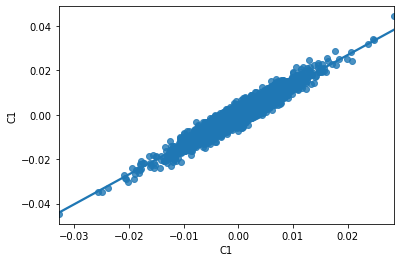

component 2


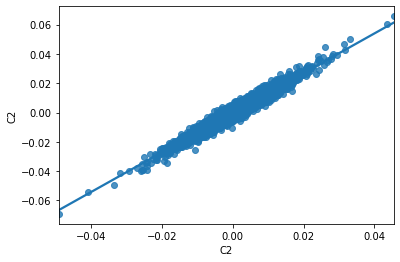

component 3


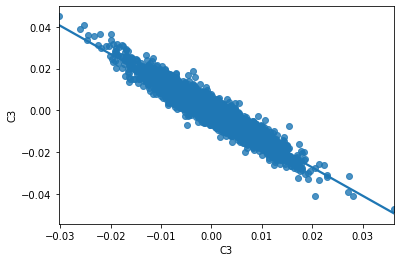

In [15]:
for i in range(1,4):
    print('component',i)
    sns.regplot(x=allcomps.loc[new_wts.index,'C%s'%i],
                y=new_wts.loc[:,'C%s'%i])
    plt.show()

It seems we have to invert the C3 values. By looking at the source code, it seems I can do this by just multiply the 3rd rotations_ vector by -1 (would be the coef_ vector for predict rather than transform)

In [16]:
mp = np.ones(pls_mod.x_rotations_.shape)
mp[:,2] = -1
pls_mod.x_rotations_ *= mp


In [16]:
for col in ['C1','C2','C3']:
    allcomps.loc[:,'abs_%s'%col] = abs(allcomps[col].values)
    allcomps.sort_values('abs_%s'%col,inplace=True,ascending=False)
    allcomps.loc[:,'%sind'%col] = range(len(allcomps))

In [25]:
round(len(allcomps) * 0.05/6)

130

In [161]:
for col in ['C1','C2','C3']:
    print('****',col,'****')
    pos = [x for x in allcomps.sort_values('abs_%s'%col,ascending=True
                                          ).index[:130] if x in pivoted.columns]
    neg = [x for x in allcomps.sort_values('abs_%s'%col).index[:130] if x in pivoted.columns]
    print('%s%% positive genes, %s%% negative genes present'%(round(((len(pos)/130)*100),2),
                                                              round(((len(neg)/130)*100),2)))
    weight_ratio = sum(allcomps.loc[pivoted.columns]['abs_%s'%col].values) /\
                   sum(allcomps['abs_%s'%col].values)
    print('%s%% of weight accounted for \n'%round(weight_ratio*100,2))
    

**** C1 ****
72.31% positive genes, 72.31% negative genes present
73.41% of weight accounted for 

**** C2 ****
68.46% positive genes, 68.46% negative genes present
73.61% of weight accounted for 

**** C3 ****
70.0% positive genes, 70.0% negative genes present
73.04% of weight accounted for 



In [57]:
for col in ['C1','C2','C3']:
    print(allcomps.loc[shared].sort_values('abs_%s'%col,ascending=False
                                          )[['%sind'%col,col]].head(15))

         C1ind        C1
PRRX1        0 -0.032893
MET          1  0.028420
WFDC1        2 -0.025724
AMDHD1       3 -0.024942
LXN          4  0.024828
ST3GAL6      5  0.024740
CTXN3        6 -0.023950
ARL9         7  0.023677
ASGR2       10 -0.020927
ABHD12B     11 -0.020823
SLC17A6     12  0.020779
LCP2        13 -0.020638
MGP         14  0.020616
FREM3       15 -0.020175
PDGFD       16  0.019857
          C2ind        C2
MGP           0 -0.049167
PRRX1         1  0.045387
AMDHD1        2  0.043567
MET           3 -0.041018
LXN           6 -0.033686
HCN4          7  0.032997
CPLX2        11 -0.031896
TGFBI        12  0.031725
FOXF2        13  0.031306
ADAMTSL1     16 -0.029321
CTXN3        17  0.029313
PLCH1        18  0.028380
ZIC1         19  0.028041
ZMYND10      20  0.027659
TP53I3       23 -0.027121
          C3ind        C3
VSTM1         0  0.036154
MGP           1 -0.030331
AIRE          3  0.028075
FAM135B       7  0.027401
VWA3A         8  0.027194
TNFSF13B      9 -0.026039
CY

In [ ]:
# # Apply PCA then PLS transform
# hb_pcatfm = pcamod.transform(MinMaxScaler().fit_transform(exp[exp.columns[:-1]]).T)
# preds = pls_mod.predict(hb_pcatfm)

In [18]:
for date, new_df in pivoted.groupby(level=0):
    print(new_df.index[0])

('HSB123R', 'A1C')
('HSB126R', 'A1C')
('HSB130L', 'A1C')
('HSB135R', 'A1C')
('HSB136R', 'A1C')
('HSB145R', 'A1C')
('PTB162L', 'A1C')
('PTB164R', 'A1C')
('PTB165R', 'A1C')
('PTB166R', 'A1C')
('PTB167R', 'A1C')
('RMB160L', 'A1C')
('RMB161L', 'A1C')
('RMB196R', 'A1C')
('RMB218L', 'A1C')
('RMB219L', 'AMY')


In [39]:
ID = 'HSB123R'
newdf = pivoted.loc[ID]
jnk = pcamod.transform(MinMaxScaler().fit_transform(newdf))
jnk2 = pls_mod.transform(jnk)

In [38]:
ID = 'HSB123R'
newdf = pivoted.loc[j]
species = df[df.ID==ID].Species.values[0]
npcatfm = pcamod.transform(newdf)
tfmx = pls_mod.transform(npcatfm)
sdf = pandas.DataFrame(tfmx,columns = ['C1_exp','C2_exp','C3_exp'])
sdf.loc[:,'ID'] = ID
sdf.loc[:,'Species'] = species
sdf.loc[:,'ROI'] = newdf.index.get_level_values('ROI')
sdf

,C1_exp,C2_exp,C3_exp,ID,Species,ROI
0,-4.379352,-1.842610,-3.721178,HSB123R,Human,AMY
1,-4.933370,-2.892623,-5.927732,HSB123R,Human,DFC
2,-3.921455,-3.011054,-7.295221,HSB123R,Human,HIP
3,-4.560749,-4.444807,-5.733860,HSB123R,Human,IPC
4,-4.251362,-4.033064,-4.518685,HSB123R,Human,ITC
5,-6.236107,-5.595809,-7.990527,HSB123R,Human,M1C
6,-5.006631,-0.730386,-5.540416,HSB123R,Human,MFC
7,-5.332214,-2.907314,-5.492170,HSB123R,Human,OFC
8,-4.670347,-5.355484,-7.590230,HSB123R,Human,S1C
9,-4.265538,-3.739359,-6.492393,HSB123R,Human,STC


In [35]:
print(newdf.shape)
print(npcatfm.shape)
print(tfmx.shape)

(13, 11338)
(13, 100)
(13, 3)


In [132]:
pmm = pandas.DataFrame(MinMaxScaler().fit_transform(pivoted),
                       index=pivoted.index,columns=pivoted.columns,copy=True)

In [139]:
cont = []
for ID, newdf in pivoted.groupby(level=0):
#for ID, newdf in pmm.groupby(level=0):
    print('working on',ID)
    species = df[df.ID==ID].Species.values[0]
    npcatfm = pcamod.transform(newdf)
    #npcatfm = pcamod.transform(MinMaxScaler().fit_transform(newdf.T).T)
    tfmx = pls_mod.transform(npcatfm)
    sdf = pandas.DataFrame(tfmx,columns = ['C1_exp','C2_exp','C3_exp'])
    sdf.loc[:,'ID'] = ID
    sdf.loc[:,'Species'] = species
    sdf.loc[:,'ROI'] = newdf.index.get_level_values('ROI')
    cont.append(sdf)

working on HSB123R
working on HSB126R
working on HSB130L
working on HSB135R
working on HSB136R
working on HSB145R
working on PTB162L
working on PTB164R
working on PTB165R
working on PTB166R
working on PTB167R
working on RMB160L
working on RMB161L
working on RMB196R
working on RMB218L
working on RMB219L


In [134]:
gdf = pandas.concat(cont)
gdf

,C1_exp,C2_exp,C3_exp,ID,Species,ROI
0,-0.397396,-0.688199,-0.170723,HSB123R,Human,A1C
1,0.209002,0.030962,-0.800099,HSB123R,Human,AMY
2,1.163793,-0.443799,0.850315,HSB123R,Human,CBC
3,-0.716349,-0.200732,-0.192639,HSB123R,Human,DFC
4,0.306168,-0.192207,-0.211939,HSB123R,Human,HIP
...,...,...,...,...,...,...
8,-0.635298,-0.247575,0.559362,RMB219L,Macaque,S1C
9,-0.429898,0.257363,0.160425,RMB219L,Macaque,STC
10,-0.599425,0.599014,0.005569,RMB219L,Macaque,STR
11,-0.302812,-0.337210,0.038789,RMB219L,Macaque,V1C


In [140]:
# # There is surely a faster way of doing this but I was lazy.
# # Took awhile to run on my computer

# gdf = pandas.DataFrame()
# count = 0
# # for each subject
# for i,ID in enumerate(df.ID.unique()):
#     print('working on %s of 16'%(i+1))
#     # for each region
#     for region in df.ROI.unique():
#         # pull out relevant data
#         jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
#         if jnk.shape[0] == 0: continue # skip if region missing
#         # add info to new spreadsheet
#         gdf.loc[count,'ID'] = jnk.iloc[0]['ID']
#         gdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
#         gdf.loc[count,'Species'] = jnk.iloc[0]['Species']
#         # prep for dot product (aka the "prediction")
#         jnk.index = jnk.gene_symbol.values
#         jnk = jnk.loc[shared]
#         # find PLS expression for each component
#         for c in range(1,4):
#             gdf.loc[count,'C%s_exp'%c] = np.dot(jnk['value'].values,
#                                              allcomps.loc[jnk.index,'C%s'%c].values)
#         count+=1

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16


In [21]:
# There is surely a faster way of doing this but I was lazy.
# Took awhile to run on my computer

gdf = pandas.DataFrame()
count = 0
# for each subject
for i,ID in enumerate(df.ID.unique()):
    print('working on %s of 16'%(i+1))
    # for each region
    for region in df.ROI.unique():
        # pull out relevant data
        jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
        if jnk.shape[0] == 0: continue # skip if region missing
        # add info to new spreadsheet
        gdf.loc[count,'ID'] = jnk.iloc[0]['ID']
        gdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
        gdf.loc[count,'Species'] = jnk.iloc[0]['Species']
        # prep for dot product (aka the "prediction")
        # first drop duplicates
        dups = []
        catch = []
        for ind,row in jnk.iterrows():
            x = row['gene_symbol']
            if x in catch:
                dups.append(ind)
            else:
                catch.append(x)
        jnk.drop(dups,axis=0,inplace=True)
        jnk.index = jnk.gene_symbol.values
        jnk = jnk.loc[pivoted.columns]
        # find PLS expression for each component
        npcatfm = pcamod.transform(jnk['value'].values.reshape(1,-1))
        tfmx = pls_mod.transform(npcatfm)
        for c in range(1,4):
            gdf.loc[count,'C%s_exp'%c] = tfmx[0,c-1]
#             gdf.loc[count,'C%s_exp'%c] = np.dot(jnk['value'].values,
#                                              allcomps.loc[jnk.index,'C%s'%c].values)
        count+=1

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16


In [198]:
jnk['value'].values.reshape(1,-1).shape

(1, 11338)

In [36]:
# Might want to save that so you don't have to do it again

#gdf.to_csv('./data/PEC_nhp_indiv_withCs.csv')

In [11]:
# # And load it to start from here
# gdf = pandas.read_csv('./data/PEC_nhp_indiv_withCs.csv',
#                      index_col=0)

In [22]:
# list the regions in the dataset
gdf.ROI.value_counts()

STC    16
ITC    16
S1C    16
HIP    16
AMY    16
IPC    16
VFC    16
OFC    16
CBC    15
A1C    15
MD     15
DFC    15
V1C    15
M1C    15
STR    15
MFC    14
Name: ROI, dtype: int64

In [12]:
# map each region to one of the AHBA regions
mapper = {'Sensorimotor': ['S1C','M1C'],
          'Limbic': ['HIP','AMY'],
          'Cerebellum': ['CBC'],
          'Forebrain': ['NAC'],
          'Striatum': ['STR'],
          'Frontal': ['OFC','VFC','DFC','MFC'],
          'Temporal': ['STC','A1C','ITC'],
          'Parietal': ['IPC',],
          'Occipital': ['V1C'],
          'Thalamus': ['MD']
         }
for name, div in mapper.items():
    gdf.loc[gdf[gdf.ROI.isin(div)].index,'MacroStructure'] = name

In [194]:
# remove outliers
#gdf.drop([1099,777],inplace=True)

# Visualization (for fun)
For fun, we can visualize the dispersion of smaples across components


Human


/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/jacobv/pls_gxp/lib/python3.7/site-packages/ipykernel_launcher.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator


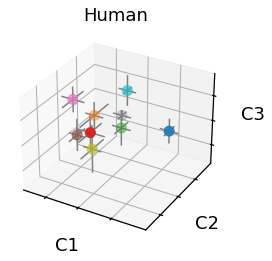

Chimpanzee


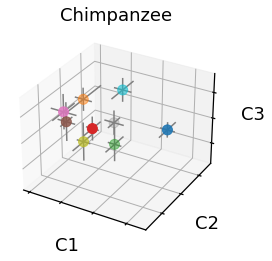

Macaque


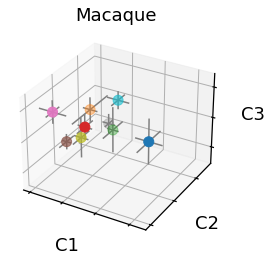

In [75]:
sns.set_context('notebook',font_scale=1.5)

# for each species separately
for species in gdf.Species.unique():
    if not pandas.notnull(species): continue
    print(species)
    adf = gdf[gdf.Species==species]
    # get means and sds across donors
    means = adf.groupby('MacroStructure')[['C1_exp','C2_exp','C3_exp']].mean()
    stds = adf.groupby('MacroStructure')[['C1_exp','C2_exp','C3_exp']].std()
    stds.columns = ['C1_sd','C2_sd','C3_sd']
    # set up plotting dataframe for easy reference
    plotr = pandas.concat([means,stds],axis=1)
    plotr.loc[:,'region'] = plotr.index
    # start building plot
    ax = plt.axes(projection='3d')
    # plot confidence intervals across all three dimensions
    for i,row in plotr.iterrows():
        c1_mn = row['C1_exp']
        c2_mn = row['C2_exp']
        c3_mn = row['C3_exp']
        c1_sd = row['C1_sd']
        c2_sd = row['C2_sd']
        c3_sd = row['C3_sd']
        ax.plot3D([c1_mn-c1_sd,c1_mn+c1_sd], [c2_mn,c2_mn], [c3_mn,c3_mn], 'gray')
        ax.plot3D([c1_mn,c1_mn], [c2_mn-c2_sd,c2_mn+c2_sd], [c3_mn,c3_mn], 'gray')
        ax.plot3D([c1_mn,c1_mn], [c2_mn,c2_mn], [c3_mn-c3_sd,c3_mn+c3_sd], 'gray')
    # plot markers
    ax.scatter3D(plotr.C1_exp, plotr.C2_exp, plotr.C3_exp, c=range(len(plotr)),cmap='tab10',
                s=100)
    # decorate
    plt.xlabel('C1')
    plt.ylabel('C2')
    ax.set_zlabel('C3')
    ax.set_xticklabels(['' for x in ax.get_xticklabels()])
    ax.set_yticklabels(['' for x in ax.get_yticklabels()])
    ax.set_zticklabels(['' for x in ax.get_zticklabels()])
    ax.set_title(species)
    plt.show()

# Calculate reproduction of PLS Components
Here we are using the same logic we did in the `GTExWorkup.ipynb` and `BrainSpanValidation.ipynb` notebooks. We are seeing how well the PLS Components trained in AHBA replicate in *individuals* across these three datasets. Importantly, two of the datasets are non-human primates, which include data from macaques and chimps, respectively

The code below is copied (and adapted) from code used in `GTExWorkup.ipynb` and `BrainSpanValidation.ipynb`, so see these notebooks for more thorough documentation

#### First across entire human dataset (to compare to other replications)

In [13]:
abac2 = pandas.read_csv('data/GCorr_BSComp_ABA_C2_data_ROTATION.csv',
                       index_col=0)
abac2.columns = ['ABA_mean','ABA_sem']
print('shared:',set(abac2.index) & set(gdf.MacroStructure.unique()))
print('missing:',set(gdf.MacroStructure.unique()) - set(abac2.index))

bsc2 = pandas.pivot_table(gdf,
                            #gdf[gdf.Age_Stage=='adult'],
                          values='C2_exp',
                             index='MacroStructure',aggfunc=np.mean
                            )
for div in bsc2.index:
    sem = gdf[gdf.MacroStructure==div]['C2_exp'].sem()
    bsc2.loc[div,'sem'] = sem
bsc2.columns = ['BS_mean','BS_sem']

c2_comp = pandas.concat([bsc2,abac2],axis=1,sort='True').dropna()
c2_comp.loc[:,'region'] = c2_comp.index
c2_comp.head()

shared: {'Sensorimotor', 'Limbic', 'Frontal', 'Thalamus', 'Temporal', 'Striatum', 'Cerebellum', 'Parietal', 'Occipital'}
missing: set()


,BS_mean,BS_sem,ABA_mean,ABA_sem,region
Cerebellum,-4.191678,0.196392,-0.706893,0.019982,Cerebellum
Frontal,-2.977417,0.218577,0.789432,0.031165,Frontal
Limbic,-2.880843,0.165415,0.030956,0.039398,Limbic
Occipital,-6.481108,0.319687,-1.655174,0.042085,Occipital
Parietal,-5.721942,0.225550,-1.124981,0.031968,Parietal


In [14]:
# z-score data to account for standardized vs. non-standardize nature of the two datasets
n_comps = 3
for i in range(1,(n_comps+1)):
    vals = StandardScaler().fit_transform(gdf.loc[:,'C%s_exp'%i
                                                 ].values.reshape(-1,1)
                                         )[:,0]
    gdf.loc[:,'zC%s_exp'%i,] = vals

In [15]:
figdir = '/Users/jacobv/Dropbox/Work/Projects/PLS_ABA/Manuscript/Figs/PostFix/subfigs/'

r = 0.961, p = 0.0


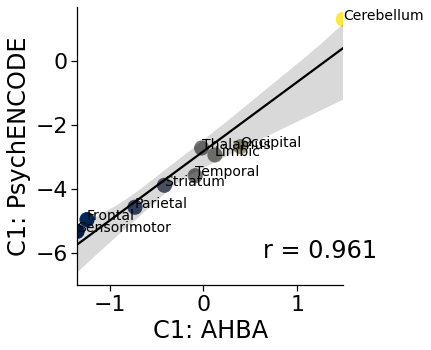

r = 0.912, p = 0.001


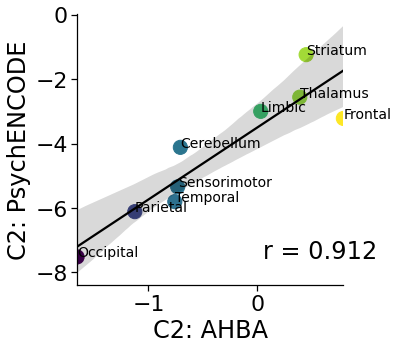

r = 0.876, p = 0.002


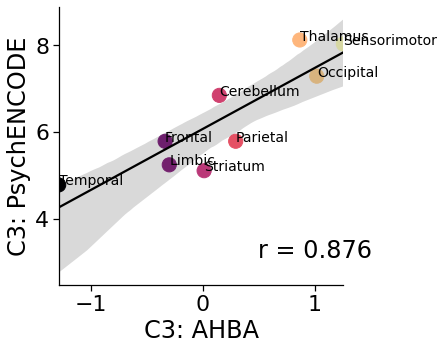

In [16]:
# note this analysis is only performed on the adult brainspan samples
sns.set_context('notebook',font_scale=2)
pals = ['cividis','viridis','magma']
for i in range(1,(n_comps+1)):
    # read allen data
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data_ROTATION.csv'%i,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    # prep brainspan data
    bs = pandas.pivot_table(#gdf,
                            gdf[gdf.Species=='Human'],# just the humans!
                          values='C%s_exp'%i,
                             index='MacroStructure',aggfunc=np.mean
                            )
    # calculate SEM (I don't think i actually use this)
    for div in bs.index:
        sem = gdf[gdf.MacroStructure==div]['C%s_exp'%i].sem()
        bs.loc[div,'sem'] = sem
    bs.columns = ['PEC_mean','PEC_sem']
    # build comparison dataframe
    comp = pandas.concat([bs,aba],axis=1,sort='True').dropna()
    comp.loc[:,'region'] = c2_comp.index
    
    # colors
    cmap = sns.color_palette(pals[i-1],as_cmap=True)
    sg = comp.ABA_mean.values
    scaled_sg = MinMaxScaler().fit_transform(sg.reshape(-1,1))[:,0]
    norm = Normalize(vmin=np.min(scaled_sg), 
                                       vmax=np.max(scaled_sg))
    cscale = cmap(norm(scaled_sg))
    
    # plot
    g=sns.lmplot(x='ABA_mean',y='PEC_mean',data=comp,
           scatter_kws={'marker':'o','s':200,'color':cscale},
               line_kws={'color':'k'}
          )
    # stats
    r,p = stats.pearsonr(comp.ABA_mean.values,comp.PEC_mean.values)
    print('r = %s, p = %s'%(round(r,3),round(p,3)))
    # decorate
    for it,div in enumerate(comp.sort_values('ABA_mean').index):
        x = comp.loc[div,'ABA_mean']
        y = comp.loc[div,'PEC_mean']
        dist = len(div)*.02
        if it%2==0:
            plt.text(x, y,div,{'size':14})
        else:
            plt.text(x, y,div,{'size':14},
                     )
    plt.xlabel('C%s: AHBA'%i)
    plt.ylabel('C%s: PsychENCODE'%i)
    plt.text(0.7,0.1,'r = %s'%round(r,3),transform=g.ax.transAxes)
    #plt.xlim(-.45,.45)
    #plt.savefig(os.path.join(figdir,'PsyENC_Repl_C%s_ROTATED.pdf'%i), bbox_inches='tight')
    plt.show()

#### Now across individual species

In [17]:
gpdfs = {}
for i in range(1,4):
    gpdf = gdf[['ID','C%s_exp'%i,'MacroStructure']
                  ].set_index(['ID'],append=True
                             ).pivot_table(index='ID',
                                           columns='MacroStructure',
                                           values='C%s_exp'%i)
    #gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in gpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        gpdf.loc[ind,'n_valid'] = n_valid
    gpdfs.update({i: gpdf})
    

In [18]:
for c in range(1,4):
    cdf = gpdfs[c]
    aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                       index_col=0)
    aba.columns = ['ABA_mean','ABA_sem']
    aba = aba.loc[cdf.columns[:-1]]
    for i,row in cdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 4:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['ABA_mean'].values,
                              forcorr['gvec'].values)[0]
            cdf.loc[i,'C%s_r'%c] = r
            cdf.loc[i,'C%s_rho'%c] = rho

In [19]:
cols = ['ID', 'Species',]
subsum = pandas.DataFrame(gpdfs[1].index)
for col in cols:
    subsum.loc[:,col] = gdf.groupby('ID')[col].first().values
for c in range(1,4):
    subsum.loc[:,'C%s_r'%c] = gpdfs[c].loc[:,'C%s_r'%c].values
    subsum.loc[:,'C%s_rho'%c] = gpdfs[c].loc[:,'C%s_rho'%c].values
    subsum.loc[:,'n_valid'] = gpdfs[c].loc[:,'n_valid'].values

Now that we have the individual level correlations to AHBA components across all individuals and species, let's plot them!

In [20]:
# Melt the dataset for easier plotting
subsum.loc[:,'ind'] = range(len(subsum))
tall = subsum.melt('ind',['C1_r','C2_r','C3_r'],'component','expr')
tall.loc[:,'Species'] = subsum.Species.tolist() * 3

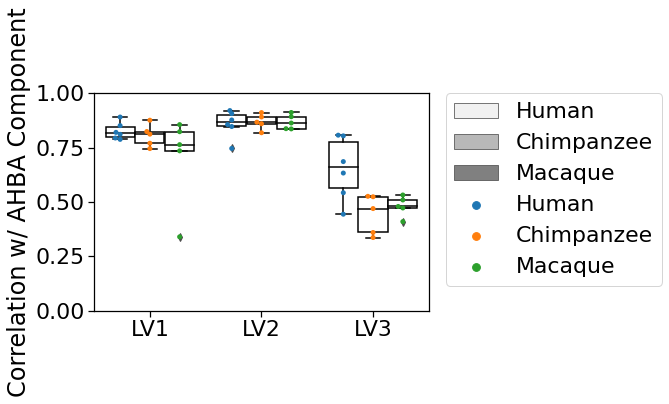

In [35]:
# Plot
sns.swarmplot(x='component',y='expr',hue='Species',data=tall,dodge=True)
g = sns.boxplot(x='component',y='expr',hue='Species',data=tall,color='gray')
plt.ylabel('Correlation w/ AHBA Component')
plt.xlabel('')
g.set_xticklabels(['LV1','LV2','LV3'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0,1)
plt.setp(g.artists, edgecolor = 'k', facecolor='w')
plt.setp(g.lines, color='k')
plt.savefig(os.path.join(figdir,'XSpecies_BasicBox.pdf'),bbox_inches='tight')

What's up with that one outlier macaque?

In [42]:
tall[tall.expr<0.15]

,ind,component,expr,Species


In [86]:
gdf[gdf.ID=='RMB219L'].MacroStructure.value_counts()

Frontal         4
Sensorimotor    2
Limbic          2
Temporal        2
Parietal        1
Striatum        1
Occipital       1
Name: MacroStructure, dtype: int64

So this subject's correlation is worse because no subcortical or cerebellar data. Very interesting. Also interesting this didn't seem to affect the data for C2

In [120]:
subsum[subsum.Species=='Macaque']['C3_r']

11    0.479112
12    0.509019
13    0.531884
14    0.409519
15    0.472218
Name: C3_r, dtype: float64

In [29]:
#tall[tall.component=='C3_r']

Let's do a quick two-way ANOVA to test if there are significant differences in similarity to the discovery dataset by species, by component, or an interaction

In [90]:
mod = smf.ols('expr ~ C(Species) + C(component) + C(Species):C(component)', data=tall).fit()
table = sm.stats.anova_lm(mod, typ=2)

In [91]:
table.round(5)

,sum_sq,df,F,PR(>F)
C(Species),0.08326,2.0,4.43821,0.01834
C(component),0.95133,2.0,50.71023,0.00000
C(Species):C(component),0.10231,4.0,2.72665,0.04293
Residual,0.36582,39.0,NaN,NaN


In [45]:
mod = smf.ols('expr ~ C(Species) + C(component) + C(Species):C(component)', data=tall).fit()
table = sm.stats.anova_lm(mod, typ=2)
table

,sum_sq,df,F,PR(>F)
C(Species),0.091283,2.0,3.957115,2.724709e-02
C(component),1.716689,2.0,74.418490,4.864390e-14
C(Species):C(component),0.072314,4.0,1.567408,2.022101e-01
Residual,0.449827,39.0,NaN,NaN


In [92]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

In [93]:
print(pairwise_tukeyhsd(tall.expr, groups=tall['Species']))

  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
  group1    group2 meandiff p-adj   lower  upper  reject
--------------------------------------------------------
Chimpanzee   Human   0.0731 0.4743 -0.0774 0.2236  False
Chimpanzee Macaque   -0.022    0.9 -0.1792 0.1352  False
     Human Macaque  -0.0951 0.2861 -0.2456 0.0553  False
--------------------------------------------------------


In [94]:
print(pairwise_tukeyhsd(tall.expr, groups=tall['component']))

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  C1_r   C2_r   0.0838 0.0931 -0.0111  0.1786  False
  C1_r   C3_r  -0.2478  0.001 -0.3427  -0.153   True
  C2_r   C3_r  -0.3316  0.001 -0.4264 -0.2367   True
----------------------------------------------------


# Null model

These correlations are all really high, and I think it's natural to wonder if the data guarantees a high correlation. So, in order to test if the within-subject r-values are greater than chance given the data, and to extract exact p-values, we'll do a bit of null modeling.

In [31]:
# n_iter = 100 # number of iterations, 100 should be fine for now
# results = []

# # for each iteration
# for it in range(n_iter):
#     # do shuffle
#     print('working on iteration',(it+1),'of',n_iter)
#     print('calculating random expression')
#     randies = {}
#     # for each component
#     for c in range(1,4):
#         # set the random state
#         prng = np.random.RandomState(123+it)
#         # shuffle the gene expression data
#         arr = allcomps.loc[shared,'C%s'%c]
#         rarr = prng.choice(arr.values,len(arr),replace=False)
#         rarr = pandas.Series(rarr,index=arr.index)
#         randies.update({c:rarr})
#     # prep a null results data frame
#     jdf = pandas.DataFrame()
#     catch = []
#     count = 0
#     # run same code as above to go through each subject and region
#     for i,ID in enumerate(df.ID.unique()):
#         print('working on %s of 16'%(i+1))
#         for region in df.ROI.unique():
#             jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
#             if jnk.shape[0] == 0: continue
#             jdf.loc[count,'ID'] = jnk.iloc[0]['ID']
#             jdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
#             jdf.loc[count,'Species'] = jnk.iloc[0]['Species']
#             jnk.index = jnk.gene_symbol.values
#             jnk = jnk.loc[shared]
#             # apply PLS weights to randomly shuffled data
#             for c in range(1,4):
#                 jdf.loc[count,'C%s_exp'%c] = np.dot(jnk['value'].values,
#                                                  randies[c].loc[jnk.index].values)
#             count+=1
#             #catch.append(jnk)
    
#     # calculate similarity
#     # same code as above, just now embedded in the loop
#     print('calculating similarity')
    
#     for name, div in mapper.items():
#         jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name
        
#     jpdfs = {}
#     for i in range(1,4):
#         jpdf = jdf[['ID','C%s_exp'%i,'MacroStructure']
#                       ].set_index(['ID'],append=True
#                                  ).pivot_table(index='ID',
#                                                columns='MacroStructure',
#                                                values='C%s_exp'%i)
#         for ind,row in jpdf.iterrows():
#             n_valid = len([x for x in row.values if pandas.notnull(x)])
#             jpdf.loc[ind,'n_valid'] = n_valid
#         jpdfs.update({i: jpdf})
    
#     for c in range(1,4):
#         cjdf = jpdfs[c]
#         aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
#                            index_col=0)
#         aba.columns = ['ABA_mean','ABA_sem']
#         aba = aba.loc[cjdf.columns[:-1]]
#         for i,row in cjdf.iterrows():
#             forcorr = pandas.DataFrame(aba,copy=True)
#             if row['n_valid'] > 4:
#                 forcorr.loc[:,'gvec'] = row.values[:-1]
#                 forcorr.dropna(inplace=True)
#                 r = stats.pearsonr(forcorr['ABA_mean'].values,
#                                   forcorr['gvec'].values)[0]
#                 rho = stats.spearmanr(forcorr['ABA_mean'].values,
#                                   forcorr['gvec'].values)[0]
#                 cjdf.loc[i,'C%s_r'%c] = r
#                 cjdf.loc[i,'C%s_rho'%c] = rho
    
#     cols = ['ID', 'Species',]
#     jsum = pandas.DataFrame(jpdfs[1].index)
#     for col in cols:
#         jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
#     for c in range(1,4):
#         jsum.loc[:,'C%s_r'%c] = jpdfs[c].loc[:,'C%s_r'%c].values
#         jsum.loc[:,'C%s_rho'%c] = jpdfs[c].loc[:,'C%s_rho'%c].values
#         jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values
#     # keep track of iteration
#     jsum.loc[:,'iteration'] = it
#     # print results to keep track of progress
#     print('='*5,it,'results','='*5)
#     print(jsum.groupby('Species')[['C1_r','C2_r','C3_r']].mean())
#     print('_'*20)
#     # store results
#     results.append(jsum)

working on iteration 1 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 0 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.515917  0.680483 -0.581268
Human       0.492940  0.776580 -0.377933
Macaque     0.245263  0.421292 -0.287731
____________________
working on iteration 2 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 13 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.773494 -0.207080 -0.100777
Human       0.588105 -0.018743 -0.116308
Macaque     0.205750 -0.060075  0.378944
____________________
working on iteration 15 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 14 results =====

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 26 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.618287  0.249828 -0.157937
Human       0.112277  0.021582 -0.499421
Macaque    -0.116263  0.335757  0.049667
____________________
working on iteration 28 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 27 results =====
                C1

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 39 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.055169 -0.320069  0.111164
Human       0.168337  0.188685  0.158563
Macaque    -0.088018 -0.732847  0.175231
____________________
working on iteration 41 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 40 results =====
                C1

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 52 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.044392 -0.624710 -0.091139
Human      -0.258758 -0.399545 -0.081341
Macaque    -0.217225 -0.370635 -0.198932
____________________
working on iteration 54 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 53 results =====

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 65 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.388252  0.156062  0.201905
Human       0.562495 -0.271824 -0.064247
Macaque     0.148844  0.344421  0.083707
____________________
working on iteration 67 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 66 results =====
                C1

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 78 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.133153 -0.120866 -0.163390
Human       0.122730  0.113958  0.029202
Macaque    -0.055133  0.398880  0.082122
____________________
working on iteration 80 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 79 results =====

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 91 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.545204  0.534860  0.695289
Human       0.651337  0.337645  0.481834
Macaque     0.447489  0.512667  0.549697
____________________
working on iteration 93 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 92 results =====
                C1

In [178]:
jnk

,ProbeID,variable,value,ID,ROI,Species,gene_symbol
SLC9A2,ENSG00000115616|SLC9A2,HSB123R.A1C,0.879480,HSB123R,A1C,Human,SLC9A2
MIA3,ENSG00000154305|MIA3,HSB123R.A1C,3.751836,HSB123R,A1C,Human,MIA3
ZNF423,ENSG00000102935|ZNF423,HSB123R.A1C,1.949611,HSB123R,A1C,Human,ZNF423
DIP2C,ENSG00000151240|DIP2C,HSB123R.A1C,1.594321,HSB123R,A1C,Human,DIP2C
ZBTB33,ENSG00000177485|ZBTB33,HSB123R.A1C,0.319741,HSB123R,A1C,Human,ZBTB33
...,...,...,...,...,...,...,...
PPIP5K2,ENSG00000145725|PPIP5K2,HSB123R.A1C,2.657745,HSB123R,A1C,Human,PPIP5K2
ISL1,ENSG00000016082|ISL1,HSB123R.A1C,0.010607,HSB123R,A1C,Human,ISL1
ZNF395,ENSG00000186918|ZNF395,HSB123R.A1C,2.444731,HSB123R,A1C,Human,ZNF395
NLGN2,ENSG00000169992|NLGN2,HSB123R.A1C,4.981238,HSB123R,A1C,Human,NLGN2


In [184]:
n_iter = 100 # number of iterations, 100 should be fine for now
results = []

# for each iteration
for it in range(n_iter):
    # do shuffle
    print('working on iteration',(it+1),'of',n_iter)
    print('calculating random expression')
    randies = {}
    # set the random state
    prng = np.random.RandomState(123+it)
    # shuffle the columns (genes)
    rarr = prng.choice(pivoted.columns,len(pivoted.columns),replace=False)
    # prep a null results data frame
    jdf = pandas.DataFrame()
    catch = []
    count = 0
    # run same code as above to go through each subject and region
    for i,ID in enumerate(df.ID.unique()):
        print('working on %s of 16'%(i+1))
        for region in df.ROI.unique():
            jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
            if jnk.shape[0] == 0: continue
            jdf.loc[count,'ID'] = jnk.iloc[0]['ID']
            jdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
            jdf.loc[count,'Species'] = jnk.iloc[0]['Species']
            jnk = jnk[jnk.gene_symbol.isin(pivoted.columns)]
             # first drop duplicates
            dups = []
            catch = []
            for ind,row in jnk.iterrows():
                x = row['gene_symbol']
                if x in catch:
                    dups.append(ind)
                else:
                    catch.append(x)
            jnk.drop(dups,axis=0,inplace=True)
            jnk.index = jnk.gene_symbol.values
            jnk = jnk.loc[rarr]
            # find PLS expression for each component
            npcatfm = pcamod.transform(jnk['value'].values.reshape(1,-1))
            tfmx = pls_mod.transform(npcatfm)
            for c in range(1,4):
                jdf.loc[count,'C%s_exp'%c] = tfmx[0,c-1]
            
            count+=1
            #catch.append(jnk)
    
    # calculate similarity
    # same code as above, just now embedded in the loop
    print('calculating similarity')
    
    for name, div in mapper.items():
        jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name
        
    jpdfs = {}
    for i in range(1,4):
        jpdf = jdf[['ID','C%s_exp'%i,'MacroStructure']
                      ].set_index(['ID'],append=True
                                 ).pivot_table(index='ID',
                                               columns='MacroStructure',
                                               values='C%s_exp'%i)
        for ind,row in jpdf.iterrows():
            n_valid = len([x for x in row.values if pandas.notnull(x)])
            jpdf.loc[ind,'n_valid'] = n_valid
        jpdfs.update({i: jpdf})
    
    for c in range(1,4):
        cjdf = jpdfs[c]
        aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
                           index_col=0)
        aba.columns = ['ABA_mean','ABA_sem']
        aba = aba.loc[cjdf.columns[:-1]]
        for i,row in cjdf.iterrows():
            forcorr = pandas.DataFrame(aba,copy=True)
            if row['n_valid'] > 4:
                forcorr.loc[:,'gvec'] = row.values[:-1]
                forcorr.dropna(inplace=True)
                r = stats.pearsonr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                rho = stats.spearmanr(forcorr['ABA_mean'].values,
                                  forcorr['gvec'].values)[0]
                cjdf.loc[i,'C%s_r'%c] = r
                cjdf.loc[i,'C%s_rho'%c] = rho
    
    cols = ['ID', 'Species',]
    jsum = pandas.DataFrame(jpdfs[1].index)
    for col in cols:
        jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
    for c in range(1,4):
        jsum.loc[:,'C%s_r'%c] = jpdfs[c].loc[:,'C%s_r'%c].values
        jsum.loc[:,'C%s_rho'%c] = jpdfs[c].loc[:,'C%s_rho'%c].values
        jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values
    # keep track of iteration
    jsum.loc[:,'iteration'] = it
    # print results to keep track of progress
    print('='*5,it,'results','='*5)
    print(jsum.groupby('Species')[['C1_r','C2_r','C3_r']].mean())
    print('_'*20)
    # store results
    results.append(jsum)

working on iteration 1 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 0 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.469075 -0.375200 -0.388267
Human       0.747459 -0.570515 -0.339455
Macaque     0.713080 -0.330766 -0.086557
____________________
working on iteration 2 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 13 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.315323  0.448359  0.375700
Human      -0.517494 -0.056273  0.202793
Macaque    -0.097905  0.279721  0.183603
____________________
working on iteration 15 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 14 results =====
                C1

working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 26 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.333243  0.103193 -0.107603
Human       0.413308  0.248422 -0.338443
Macaque     0.173710 -0.239308  0.137594
____________________
working on iteration 28 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 27 results =====
                C1

Macaque    -0.571671  0.056781  0.569080
____________________
working on iteration 40 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 39 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee  0.087012 -0.068971  0.224940
Human       0.022880  0.630978  0.194473
Macaque     0.048600 -0.052692  0.249679
____________________
working on iteration 41 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
wo

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 52 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.087815  0.660583  0.323334
Human      -0.348683  0.651046  0.163065
Macaque    -0.325849  0.446598  0.240101
____________________
working on iteration 54 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 53 results =====

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 65 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.011856  0.155632  0.060075
Human      -0.212278 -0.524983  0.001907
Macaque     0.043504 -0.351496  0.012615
____________________
working on iteration 67 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 66 results =====

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 78 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.231554 -0.438404 -0.094728
Human      -0.350883 -0.724112 -0.022655
Macaque    -0.227599 -0.768539  0.081864
____________________
working on iteration 80 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 79 results =====

working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 91 results =====
                C1_r      C2_r      C3_r
Species                                 
Chimpanzee -0.152147 -0.237326 -0.678662
Human      -0.456078  0.054534 -0.714726
Macaque    -0.408482 -0.223204 -0.489690
____________________
working on iteration 93 of 100
calculating random expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity
===== 92 results =====

In [175]:
# n_iter = 100 # number of iterations, 100 should be fine for now
# results = []

# # for each iteration
# for it in range(n_iter):
#     print('working on iteration',(it+1),'of',n_iter)
#     print('calculating random expression')
#     randies = {}
#     # set the random state
#     prng = np.random.RandomState(123+it)
#     # shuffle the columns (genes)
#     to_shuf = pandas.DataFrame(pivoted,copy=True)
#     rarr = prng.choice(pivoted.columns,len(pivoted.columns),replace=False)
#     to_shuf = to_shuf.reindex(columns = rarr)
#     # apply PLS model to randomly shuffled data
#     cont = []
#     for ID, newdf in to_shuf.groupby(level=0):
#     #for ID, newdf in pmm.groupby(level=0):
#         species = df[df.ID==ID].Species.values[0]
#         npcatfm = pcamod.transform(newdf.values)
#         #npcatfm = pcamod.transform(MinMaxScaler().fit_transform(newdf.T).T)
#         tfmx = pls_mod.transform(npcatfm)
#         sdf = pandas.DataFrame(tfmx,columns = ['C1_exp','C2_exp','C3_exp'])
#         sdf.loc[:,'ID'] = ID
#         sdf.loc[:,'Species'] = species
#         sdf.loc[:,'ROI'] = newdf.index.get_level_values('ROI')
#         cont.append(sdf)
#     jdf = pandas.concat(cont)
    
#     # calculate similarity
#     # same code as above, just now embedded in the loop
#     print('calculating similarity')
    
#     for name, div in mapper.items():
#         jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name
        
#     jpdfs = {}
#     for i in range(1,4):
#         jpdf = jdf[['ID','C%s_exp'%i,'MacroStructure']
#                       ].set_index(['ID'],append=True
#                                  ).pivot_table(index='ID',
#                                                columns='MacroStructure',
#                                                values='C%s_exp'%i)
#         for ind,row in jpdf.iterrows():
#             n_valid = len([x for x in row.values if pandas.notnull(x)])
#             jpdf.loc[ind,'n_valid'] = n_valid
#         jpdfs.update({i: jpdf})
    
#     for c in range(1,4):
#         cjdf = jpdfs[c]
#         aba = pandas.read_csv('data/GCorr_BSComp_ABA_C%s_data.csv'%c,
#                            index_col=0)
#         aba.columns = ['ABA_mean','ABA_sem']
#         aba = aba.loc[cjdf.columns[:-1]]
#         for i,row in cjdf.iterrows():
#             forcorr = pandas.DataFrame(aba,copy=True)
#             if row['n_valid'] > 4:
#                 forcorr.loc[:,'gvec'] = row.values[:-1]
#                 forcorr.dropna(inplace=True)
#                 r = stats.pearsonr(forcorr['ABA_mean'].values,
#                                   forcorr['gvec'].values)[0]
#                 rho = stats.spearmanr(forcorr['ABA_mean'].values,
#                                   forcorr['gvec'].values)[0]
#                 cjdf.loc[i,'C%s_r'%c] = r
#                 cjdf.loc[i,'C%s_rho'%c] = rho
    
#     cols = ['ID', 'Species',]
#     jsum = pandas.DataFrame(jpdfs[1].index)
#     for col in cols:
#         jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
#     for c in range(1,4):
#         jsum.loc[:,'C%s_r'%c] = jpdfs[c].loc[:,'C%s_r'%c].values
#         jsum.loc[:,'C%s_rho'%c] = jpdfs[c].loc[:,'C%s_rho'%c].values
#         jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values
#     # keep track of iteration
#     jsum.loc[:,'iteration'] = it
#     # print results to keep track of progress
#     print('='*5,it,'results','='*5)
#     print(jsum.groupby('Species')[['C1_r','C2_r','C3_r']].mean())
#     print('_'*20)
#     # store results
#     results.append(jsum)

In [185]:
# concatenate results
randos = pandas.concat(results)

In [186]:
##save it, so you don't have to run that whole thing again
#randos.to_csv('./data/random_mats_ROTATION_again.csv')

In [33]:
# save it, so you don't have to run that whole thing again
#randos.to_csv('./data/random_mats_ROTATION.csv')

In [36]:
# load it if necessary
#randos = pandas.read_csv('./data/random_mats_ROTATION_again.csv',index_col=0)

In [37]:
# build it into a summarized dataframe
randos.loc[:,'ind'] = range(len(randos)) 
rtall = randos.melt('ind',['C1_r','C2_r','C3_r'],'component','expr')
rtall.loc[:,'Species'] = ['%s_Null'%x for x in randos.Species] * 3
rtall.loc[:,'Species2'] = [x for x in randos.Species] * 3
rtall.loc[:,'ID'] = [x for x in randos.ID] * 3

In [38]:
# concatenate it with the "true" results for comparison
vtall = pandas.concat([tall,rtall])

In [39]:
# set some colors
pal = [sns.color_palette('cividis')[-2],
       sns.color_palette('viridis')[-2],
       sns.color_palette('magma')[-2]]

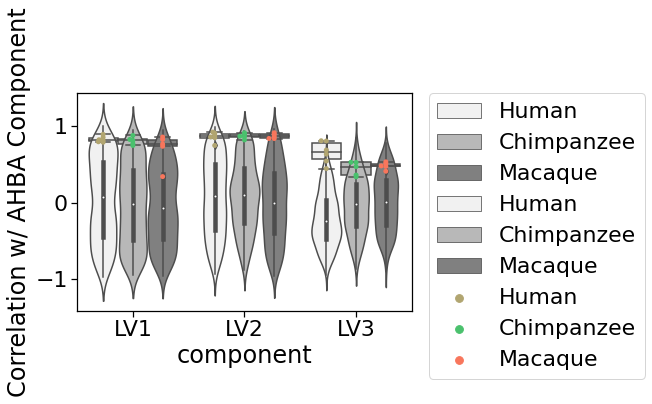

In [41]:
# plot the null distributions as violin plots over the boxplots from 
# earlier. NOTE: this aggregates null distributions across donors
# which doesn't make that much sense, as each donor has different data
# and therefore has their own unique null.
sns.swarmplot(x='component',y='expr',hue='Species',data=tall,dodge=True,palette=pal)
sns.boxplot(x='component',y='expr',hue='Species',data=tall,color='gray')
plt.ylabel('Correlation w/ AHBA Component')
g = sns.violinplot(x='component',y='expr',hue='Species2',data=rtall,color='gray')
plt.ylabel('Correlation w/ AHBA Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['LV1','LV2','LV3'])
plt.savefig(os.path.join(figdir,'XSpecies_null_simple_ROTATED.pdf'),
          bbox_inches='tight')

[Text(0, 0, 'C1'), Text(1, 0, 'C2'), Text(2, 0, 'C3')]

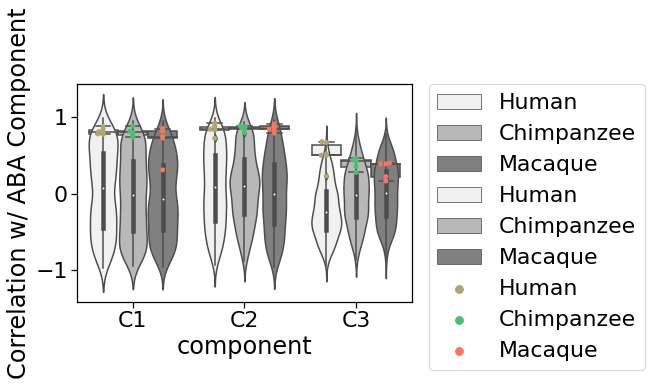

In [54]:
# plot the null distributions as violin plots over the boxplots from 
# earlier. NOTE: this aggregates null distributions across donors
# which doesn't make that much sense, as each donor has different data
# and therefore has their own unique null.
sns.swarmplot(x='component',y='expr',hue='Species',data=tall,dodge=True,palette=pal)
sns.boxplot(x='component',y='expr',hue='Species',data=tall,color='gray')
plt.ylabel('Correlation w/ ABA Component')
g = sns.violinplot(x='component',y='expr',hue='Species2',data=rtall,color='gray')
plt.ylabel('Correlation w/ ABA Component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(['LV1','C2','C3'])
# plt.savefig(os.path.join(figdir,'XSpecies_null_simple_ROTATED.pdf'),
#            bbox_inches='tight')

To overcome the *note* above, I wanted to plot the individual level null distributions against the "true" values. 

In [43]:
tall.loc[:,'ID'] = subsum.ID.tolist() * 3

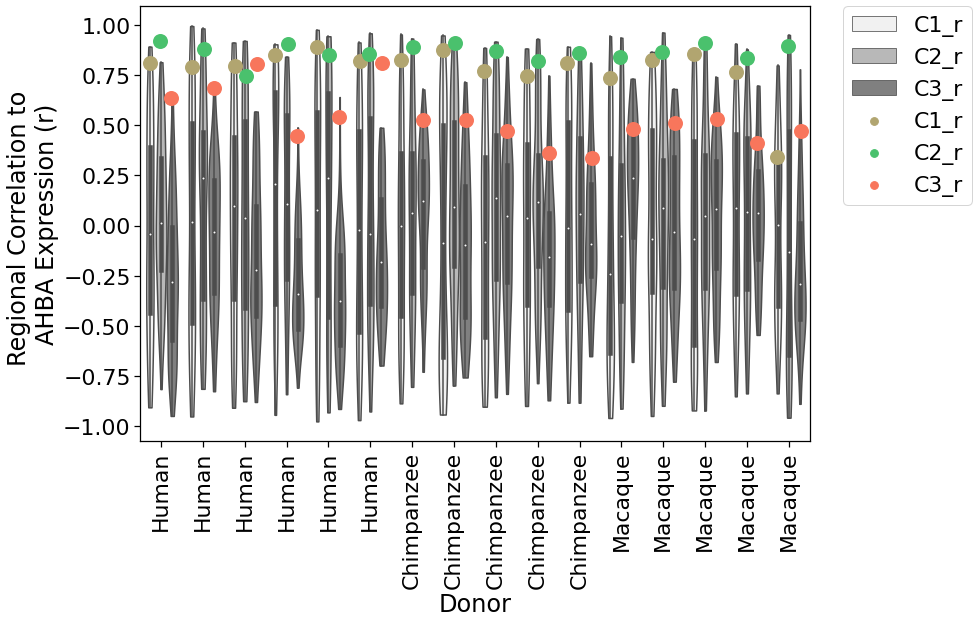

In [44]:
plt.subplots(figsize=(12,8))
sns.stripplot(x='ID',y='expr',hue='component',data=tall,
              palette=pal,dodge=True,s=15)
g = sns.violinplot(x='ID',y='expr',data=rtall,color='gray',cut=0,
                   hue='component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(subsum.Species.tolist(),rotation=90)
plt.xlabel('Donor')
plt.ylabel('Regional Correlation to \nAHBA Expression (r)')
plt.savefig(os.path.join(figdir,'XSpecies_null_indiv_ROTATAED.pdf'),
           bbox_inches='tight')

Text(0, 0.5, 'Regional Correlation to \nABA Expression (r)')

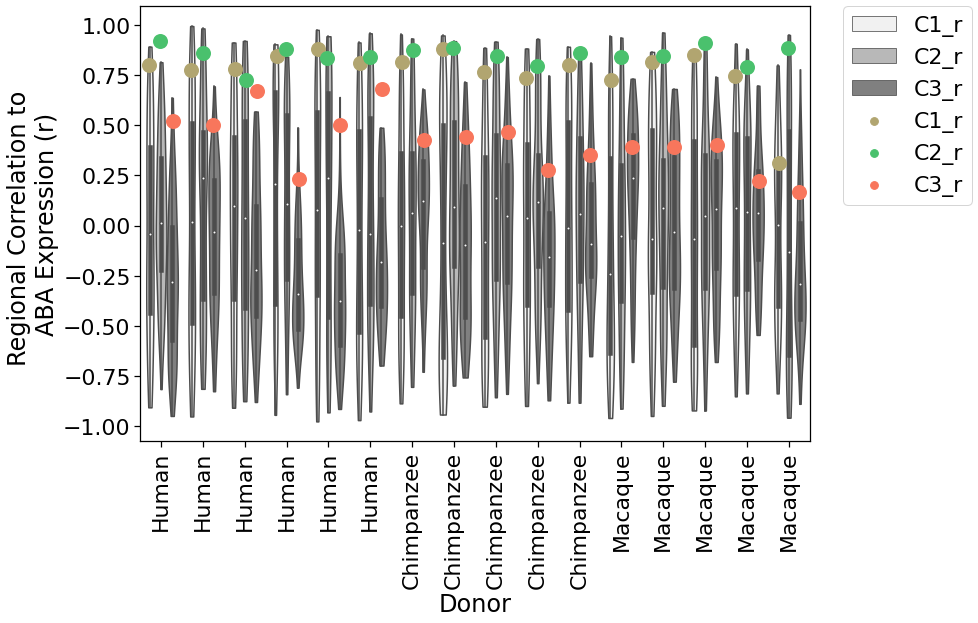

In [192]:
plt.subplots(figsize=(12,8))
sns.stripplot(x='ID',y='expr',hue='component',data=tall,
              palette=pal,dodge=True,s=15)
g = sns.violinplot(x='ID',y='expr',data=rtall,color='gray',cut=0,
                   hue='component')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
g.set_xticklabels(subsum.Species.tolist(),rotation=90)
plt.xlabel('Donor')
plt.ylabel('Regional Correlation to \nABA Expression (r)')
# plt.savefig(os.path.join(figdir,'XSpecies_null_indiv_ROTATAED.pdf'),
#            bbox_inches='tight')

In [101]:
# generate exact p-values for each subject
for i,row in subsum.iterrows():
    for c in range(1,4):
        null = randos[randos.ID==row['ID']]['C%s_r'%c].sort_values().values
        val = row['C%s_r'%c]
        p = len(null[null>val]) / len(null)
        subsum.loc[i,'C%s_p(r)'%c] = p

In [102]:
subsum

,ID,Species,C1_r,C1_rho,n_valid,C2_r,C2_rho,C3_r,C3_rho,ind,C1_p(r),C2_p(r),C3_p(r)
0,HSB123R,Human,0.810853,0.700000,9.0,0.920121,0.883333,0.632811,0.633333,0,0.02,0.00,0.01
1,HSB126R,Human,0.787683,0.683333,9.0,0.876948,0.950000,0.685544,0.700000,1,0.09,0.06,0.01
2,HSB130L,Human,0.793901,0.716667,9.0,0.745947,0.866667,0.803778,0.883333,2,0.07,0.15,0.00
3,HSB135R,Human,0.850960,0.750000,9.0,0.906302,0.866667,0.443558,0.700000,3,0.07,0.00,0.01
4,HSB136R,Human,0.890428,0.761905,8.0,0.846779,0.880952,0.542311,0.452381,4,0.04,0.07,0.01
5,HSB145R,Human,0.819930,0.833333,9.0,0.855912,0.883333,0.806991,0.783333,5,0.06,0.03,0.00
6,PTB162L,Chimpanzee,0.823741,0.800000,9.0,0.890493,0.916667,0.525783,0.733333,6,0.02,0.01,0.05
7,PTB164R,Chimpanzee,0.875811,0.833333,8.0,0.910892,0.976190,0.523795,0.785714,7,0.02,0.03,0.05
8,PTB165R,Chimpanzee,0.769885,0.733333,9.0,0.866810,0.816667,0.469447,0.483333,8,0.05,0.03,0.11
9,PTB166R,Chimpanzee,0.745312,0.650000,9.0,0.818136,0.866667,0.359449,0.600000,9,0.08,0.04,0.10


# PC comparison

Okay, so these are almost all significant for all components. Not terribly surprising. But, there is maybe another null model necessary. One might just point out that perhaps the overall brain gene expression patterns across species is highly similar, and that any biological signal will be highly reproducible across datasets. So, here we want to set up a distribution of r-values (representing reproducibility) for other biologically meaningful signals, to see how common it is to demonstrate a reproducible regional expression pattern across these datasets.

The easiest way to drum up a bunch of biological signals is probably to use the AHBA prinicipal components. So, we'll create a distribution of r-values across AHBA PCs, and compare our PLS Component r-values to this distribution

In [45]:
g2=pandas.read_csv('data/MAIN_gcx_wholebrain_info_W_BRAIN_DIVISIONS.csv',
                  index_col=0)
g2.drop(g2.columns[0],axis=1,inplace=True)
g2 = g2.loc[hgdf.index]

In [46]:
tfm_X,tfm_Y = pls_mod.transform(pca_tfm, full_y)
g2.loc[:,'C1_orig'] = tfm_X[:,0]
g2.loc[:,'C2_orig'] = tfm_X[:,1]
g2.loc[:,'C3_orig'] = tfm_X[:,2]

In [47]:
#pcdiv = pandas.read_csv('./data/Allen_Macrostructure_PCs.csv',index_col = 0)
allpcs = []
for pc in range(pca_tfm.shape[1]):
    g2.loc[:,'PC'] = pca_tfm.loc[:,pc]
    c_vals = pandas.pivot_table(g2,values='PC',
                                 index='brain_divison',aggfunc=np.mean
                                )
    c_vals.columns = ['PC%s'%pc]
    allpcs.append(c_vals)
pcdiv = pandas.concat(allpcs,axis=1)

In [48]:
#pcs = pandas.read_csv('./data/Allen_PC_matrix.csv',index_col = 0)
pcs = pandas.DataFrame(pcamod.components_,columns=pivoted.columns,
                 index=['C%s'%x for x in range(pcamod.components_.shape[0])]).T

In [45]:
# # this is pretty much the same code as above, but adapted to use the
# # Allen PCs rather than scrambled data
# print('calculating PC expression')
# jdf = pandas.DataFrame(columns = pcs.columns)
# catch = []
# count = 0
# for i,ID in enumerate(df.ID.unique()):
#     print('working on %s of 16'%(i+1))
#     for region in df.ROI.unique():
#         jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
#         if jnk.shape[0] == 0: continue
#         jdf.loc[count,'ID'] = jnk.iloc[0]['ID']
#         jdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
#         jdf.loc[count,'Species'] = jnk.iloc[0]['Species']
#         jnk.index = jnk.gene_symbol.values
#         jnk = jnk.loc[shared]
#         jdf.loc[count,pcs.columns] = np.dot(jnk['value'].values,pcs.loc[jnk.index].values)
#         count+=1
#         #catch.append(jnk)

# # calculate similarity
# print('calculating similarity')
# for name, div in mapper.items():
#     jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name

# # stupid value conversion
# jnk = pandas.DataFrame(pandas.to_numeric(jdf[pcs.columns].values.flat,
#                                           ).reshape(len(jdf),len(pcs.columns)),
#                       index = jdf,columns=pcs.columns)
# for col in [x for x in jdf.columns if x not in jnk.columns]:
#     jnk.loc[:,col] = jdf[col].values
# jdf = jnk

# jpdfs = {}
# for pc in pcs.columns:
#     jpdf = jdf[['ID',pc,'MacroStructure']
#                   ].set_index(['ID'],append=True
#                              ).pivot_table(index='ID',
#                                            columns='MacroStructure',
#                                            values=pc)
#     #gpdf.drop('GangEm',axis=1,inplace=True)
#     for ind,row in jpdf.iterrows():
#         n_valid = len([x for x in row.values if pandas.notnull(x)])
#         jpdf.loc[ind,'n_valid'] = n_valid
#     jpdfs.update({pc: jpdf})

# for c in pcs.columns:
#     cjdf = jpdfs[c]
#     aba = pandas.DataFrame(pcdiv['P%s'%c])
#     aba = aba.loc[cjdf.columns[:-1]]
#     for i,row in cjdf.iterrows():
#         forcorr = pandas.DataFrame(aba,copy=True)
#         if row['n_valid'] > 4:
#             forcorr.loc[:,'gvec'] = row.values[:-1]
#             forcorr.dropna(inplace=True)
#             r = stats.pearsonr(forcorr['P%s'%c].values,
#                               forcorr['gvec'].values)[0]
#             rho = stats.spearmanr(forcorr['P%s'%c].values,
#                               forcorr['gvec'].values)[0]
#             cjdf.loc[i,'%s_r'%c] = r
#             cjdf.loc[i,'%s_rho'%c] = rho

# cols = ['ID', 'Species',]
# jsum = pandas.DataFrame(jpdfs[list(jpdfs.keys())[0]].index)
# for col in cols:
#     jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
# for c in pcs.columns:
#     jsum.loc[:,'%s_r'%c] = jpdfs[c].loc[:,'%s_r'%c].values
#     jsum.loc[:,'%s_rho'%c] = jpdfs[c].loc[:,'%s_rho'%c].values
#     jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values

calculating PC expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity


In [49]:
# this is pretty much the same code as above, but adapted to use the
# Allen PCs rather than scrambled data
print('calculating PC expression')
jdf = pandas.DataFrame(columns = pcs.columns)
catch = []
count = 0
for i,ID in enumerate(df.ID.unique()):
    print('working on %s of 16'%(i+1))
    for region in df.ROI.unique():
        jnk = pandas.DataFrame(df[(df.ROI==region) & (df.ID==ID)],copy=True)
        if jnk.shape[0] == 0: continue
        jdf.loc[count,'ID'] = jnk.iloc[0]['ID']
        jdf.loc[count,'ROI'] = jnk.iloc[0]['ROI']
        jdf.loc[count,'Species'] = jnk.iloc[0]['Species']
        
        jnk = jnk[jnk.gene_symbol.isin(pivoted.columns)]
        # first drop duplicates
        dups = []
        catch = []
        for ind,row in jnk.iterrows():
            x = row['gene_symbol']
            if x in catch:
                dups.append(ind)
            else:
                catch.append(x)
        jnk.drop(dups,axis=0,inplace=True)
        
        jnk.index = jnk.gene_symbol.values
        jnk = jnk.loc[pivoted.columns]
        jdf.loc[count,pcs.columns] = pcamod.transform(jnk['value'].values.reshape(1,-1))[0]
        #jdf.loc[count,pcs.columns] = np.dot(jnk['value'].values,pcs.loc[jnk.index].values)
        count+=1
        #catch.append(jnk)

# calculate similarity
print('calculating similarity')
for name, div in mapper.items():
    jdf.loc[jdf[jdf.ROI.isin(div)].index,'MacroStructure'] = name

#stupid value conversion
jnk = pandas.DataFrame(pandas.to_numeric(jdf[pcs.columns].values.flat,
                                          ).reshape(len(jdf),len(pcs.columns)),
                      index = jdf,columns=pcs.columns)
for col in [x for x in jdf.columns if x not in jnk.columns]:
    jnk.loc[:,col] = jdf[col].values
jdf = jnk

jpdfs = {}
for pc in pcs.columns:
    jpdf = jdf[['ID',pc,'MacroStructure']
                  ].set_index(['ID'],append=True
                             ).pivot_table(index='ID',
                                           columns='MacroStructure',
                                           values=pc)
    #gpdf.drop('GangEm',axis=1,inplace=True)
    for ind,row in jpdf.iterrows():
        n_valid = len([x for x in row.values if pandas.notnull(x)])
        jpdf.loc[ind,'n_valid'] = n_valid
    jpdfs.update({pc: jpdf})

for c in pcs.columns:
    cjdf = jpdfs[c]
    aba = pandas.DataFrame(pcdiv['P%s'%c])
    aba = aba.loc[cjdf.columns[:-1]]
    for i,row in cjdf.iterrows():
        forcorr = pandas.DataFrame(aba,copy=True)
        if row['n_valid'] > 4:
            forcorr.loc[:,'gvec'] = row.values[:-1]
            forcorr.dropna(inplace=True)
            r = stats.pearsonr(forcorr['P%s'%c].values,
                              forcorr['gvec'].values)[0]
            rho = stats.spearmanr(forcorr['P%s'%c].values,
                              forcorr['gvec'].values)[0]
            cjdf.loc[i,'%s_r'%c] = r
            cjdf.loc[i,'%s_rho'%c] = rho

cols = ['ID', 'Species',]
jsum = pandas.DataFrame(jpdfs[list(jpdfs.keys())[0]].index)
for col in cols:
    jsum.loc[:,col] = jdf.groupby('ID')[col].first().values
for c in pcs.columns:
    jsum.loc[:,'%s_r'%c] = jpdfs[c].loc[:,'%s_r'%c].values
    jsum.loc[:,'%s_rho'%c] = jpdfs[c].loc[:,'%s_rho'%c].values
    jsum.loc[:,'n_valid'] = jpdfs[c].loc[:,'n_valid'].values

calculating PC expression
working on 1 of 16
working on 2 of 16
working on 3 of 16
working on 4 of 16
working on 5 of 16
working on 6 of 16
working on 7 of 16
working on 8 of 16
working on 9 of 16
working on 10 of 16
working on 11 of 16
working on 12 of 16
working on 13 of 16
working on 14 of 16
working on 15 of 16
working on 16 of 16
calculating similarity


In [50]:
subsum.groupby('Species').mean()

,C1_r,C1_rho,n_valid,C2_r,C2_rho,C3_r,C3_rho,ind
Species,,,,,,,,
Chimpanzee,0.805299,0.746667,8.800000,0.869188,0.901905,0.442944,0.610476,8.0
Human,0.825626,0.740873,8.833333,0.858668,0.888492,0.652499,0.692063,2.5
Macaque,0.703268,0.650952,8.600000,0.867757,0.865238,0.480350,0.546667,13.0


In [51]:
# now let't melt that df
jsum.loc[:,'ind'] = range(len(jsum))
jtall = jsum.melt('ind',[x for x in jsum.columns if '_r' in x and 'ho' not in x],
                  'component','expr')
jtall.loc[:,'Species'] = jsum.Species.tolist() * len(pcs.columns)
jtall.loc[:,'ID'] = jsum.ID.tolist() * len(pcs.columns)

jtall.loc[:,'c'] = [int(x.split('C')[1].split('_')[0]) for x in jtall.component.values]

In [52]:
# generating p-values
comps = pandas.DataFrame(index=jsum.ID.values)
for i,row in jsum.iterrows():
    ID = row['ID']
    dist = row[[x for x in jsum.columns if '_r' in x and 'ho' not in x]].values
    for c in range(1,4):
        val = subsum[subsum.ID==ID]['C%s_r'%c].values[0]
        p = len(dist[dist>val]) / 100
        
        comps.loc[ID,'C%s'%c] = p
    sig = sorted(dist)[95]
    comps.loc[ID,'sig'] = sig

In [53]:
# having a look
comps

,C1,C2,C3,sig
HSB123R,0.05,0.03,0.11,0.889980
HSB126R,0.10,0.06,0.16,0.901669
HSB130L,0.10,0.11,0.08,0.894499
HSB135R,0.05,0.04,0.25,0.855502
HSB136R,0.04,0.05,0.22,0.876036
HSB145R,0.07,0.05,0.07,0.874710
PTB162L,0.09,0.02,0.30,0.871551
PTB164R,0.04,0.03,0.26,0.822631
PTB165R,0.11,0.06,0.35,0.875877
PTB166R,0.16,0.08,0.56,0.931585


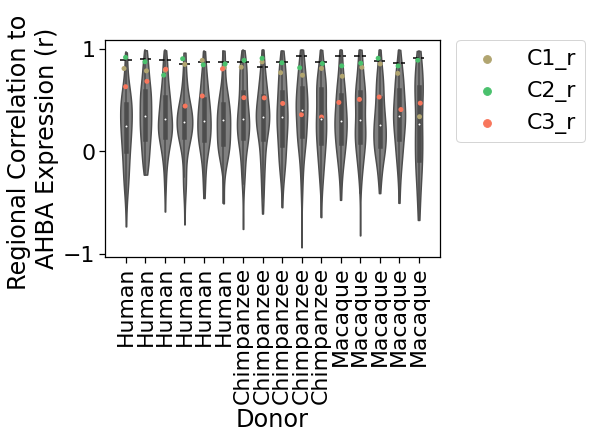

In [54]:
# And now we plot the "null" distribution, along with the "true"
# r-values of the PLS Components
sns.stripplot(x='ID',y='expr',hue='component',data=tall,palette=pal)
g = sns.violinplot(x='ID',y='expr',data=jtall,color='gray',cut=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
count = 0
for i,row in comps.iterrows():
    plt.plot([(count-0.3),(count+0.3)],[row['sig'],row['sig']],ls='--',c='k')
    count+=1
g.set_xticklabels(subsum.Species.tolist(),rotation=90)
plt.xlabel('Donor')
plt.ylabel('Regional Correlation to \nAHBA Expression (r)')
plt.savefig(os.path.join(figdir,'XSpecies_signull_indiv_ROTATED.pdf'),
           bbox_inches='tight')

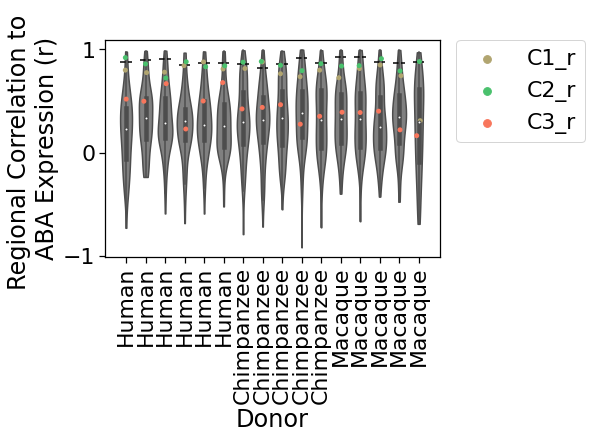

In [69]:
# And now we plot the "null" distribution, along with the "true"
# r-values of the PLS Components
sns.stripplot(x='ID',y='expr',hue='component',data=tall,palette=pal)
g = sns.violinplot(x='ID',y='expr',data=jtall,color='gray',cut=0)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
count = 0
for i,row in comps.iterrows():
    plt.plot([(count-0.3),(count+0.3)],[row['sig'],row['sig']],ls='--',c='k')
    count+=1
g.set_xticklabels(subsum.Species.tolist(),rotation=90)
plt.xlabel('Donor')
plt.ylabel('Regional Correlation to \nABA Expression (r)')
plt.savefig(os.path.join(figdir,'XSpecies_signull_indiv_ROTATED.pdf'),
           bbox_inches='tight')

In [232]:
120000/22

5454.545454545455